# 衣服鞋帽图像识别问题-基于Keras
## 问题描述
Fashion Mnist数据集由70,000张黑白图片构成，每张图片大小为 28x28，由十类服饰图片构成。
## 解决思路
1. 获取数据，包括训练数据和测试数据。
2. 模型建立
3. 模型训练
4. 模型验证

### 步骤1 引入必要的库
本试验使用 tf.keras来和训练Tensorflow模型

In [1]:
#Tensorflow 与 tf.keras
import tensorflow as tf
from tensorflow import keras

#numpy 与 matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile 
import gzip

%matplotlib inline
print(tf.__version__)


1.13.1


### 步骤2 载入数据与数据预处理
#### 步骤2.1 载入Fashion MNIST数据集

In [3]:
path='./data/'

def load_data(path):
    with gzip.open(os.path.join(path,'train-labels-idx1-ubyte.gz'),'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(),np.uint8,offset=8)
    with gzip.open(os.path.join(path,'train-images-idx3-ubyte.gz'),'rb') as imgpath:
        x_train= np.frombuffer(imgpath.read(), np.uint8, offset=16).reshape(len(y_train),28,28)
    with gzip.open(os.path.join(path,'t10k-labels-idx1-ubyte.gz'),'rb') as lbpath:
        y_test= np.frombuffer(lbpath.read(), np.uint8, offset=8)
    with gzip.open(os.path.join(path,'t10k-images-idx3-ubyte.gz'),'rb') as imgpath:
        x_test= np.frombuffer(imgpath.read(), np.uint8, offset=16).reshape(len(y_test),28,28)
    return (x_train, y_train), (x_test,y_test)

(train_images,train_labels), (test_images, test_labels) = load_data(path)

# 数据集 label_list
class_names = ['T-shirt/top','Trouser', 'Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

train_images和tain_tags是训练集数据，即模型用于学习的数据
test_images和test_tags是训练集

这些图像都是28*28的数组，像素值从0到255不等。label是一个整数数组，范围从0到9，表示对应于图像所代表的服装的类别。
每个图像都映射到一个标签。由于数据集中没有包含类名，所以将它们存储在这里，以便以后绘画时使用

#### 步骤2.2 研究数据
在训练模型之前，查看一下数据集的格式

In [4]:
print('训练集中有60000张图像，每张图像表示为28*28像素：',train_images.shape)
print('训练集中Label数量：',len(train_labels))
print('Label的种类：',set(train_labels))
print('测试集中有10000张图像，每张图像表示为28*28像素：',test_images.shape)
print('测试集中Label数量：',len(test_labels))

训练集中有60000张图像，每张图像表示为28*28像素： (60000, 28, 28)
训练集中Label数量： 60000
Label的种类： {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
测试集中有10000张图像，每张图像表示为28*28像素： (10000, 28, 28)
测试集中Label数量： 10000


#### 步骤2.3 预处理数据
在训练模型之前，必须对数据进行预处理。检查训练集中的第一张图像，你会发现像素值在0到255之间
在将这些值输入神经网络模型之前，需要进行归一化处理，将这些值缩放到0到1的范围。因此，将数据值除以255.

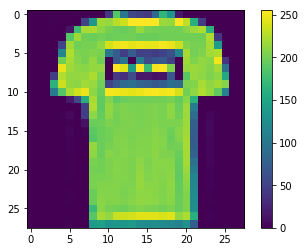

In [5]:
plt.figure()
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

#数据预处理
train_images = train_images / 255.0
test_images = test_images / 255.0

#### 步骤2.4 验证数据格式
为了验证数据的格式是否正确，显示来自training set的前30张图像，并在每张图像下面显示类名。

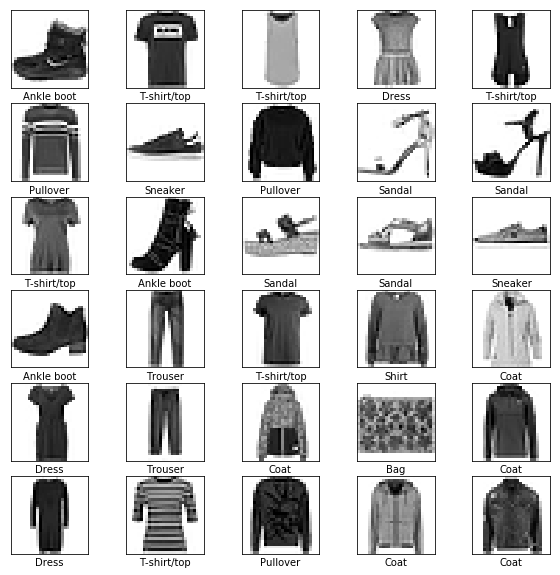

In [7]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i],cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### 步骤3 建立模型
构建神经网络需要对模型的层进行配置，然后对模型进行编译
#### 步骤3.1 设置图层
神经网络的基本构件是layer。层从输入的数据中提前特征。这些特征将会所预测的问题有很大的作用。
大多数深度学习都是由简单层次链接组成的。最常用的层tf.keras.layers.Dense，参数是在训练中自动学习的。

In [8]:
#构建模型
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10,activation='softmax') 
])

#模型预览
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


神经网络的第一层，tf.keras.layers.Flatten，将图像从二维数组（28* 28像素）转换为一维数组（28* 28=784像素）。这个层可以看作是将图像中的像素分解并排列起来。这一层没有需要学习的参数，它只重新格式化数据。
当像素被压平后，神经网络有两个tf.keras.layer.Dense组成。这些层为全连接层，或者称为稠密层。第一个Dense层有128个神经元。第二个Dense层是一个10节点的softmax层，它返回一个由10个概率值组成的数组，其和为1.每个节点包含一个概率值，表示当前图像属于10个类别中的某一个的概率

#### 步骤3.2编译模型
在模型训练之前，需要更多的设置。这些是在模型的compile中添加的：
- loss 测量模型在训练期间的准确性。我们想要最小化这个函数来训练模型朝着正确的方向。
- optimizer这是根据模型所看到的数据及其损失函数更新模型的方法。
- metrics用于检测训练和测试。下面的例子使用了accuracy，即正确分类的图像的比例

In [9]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

### 步骤4 训练模型
#### 步骤4.1 在训练集上训练模型
训练神经网络模型需要以下步骤：
1. 将训练数据提供给模型。在本实验中，训练数据是train_images和train_tags数组
2. 模型学会将图像与标签进行映射
3. 使用模型对一个测试集做出预测，在这个实验中是test_images，验证预测值与test_tags标签的匹配度。

使用model.fit训练模型


In [10]:
# 忍耐参数（patience parameter），检查在某些训练周期中模型是否不断改进，当模型训练不再使用模型更好时停止训练
early_stop= keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

measure = model.fit(
    train_images,train_labels,
    epochs=100,
    validation_data=(test_images,test_labels),
    callbacks=[early_stop]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 96us/sample - loss: 0.4951 - acc: 0.8263 - val_loss: 0.4423 - val_acc: 0.8443
Epoch 2/100
60000/60000 [==============================] - 6s 97us/sample - loss: 0.3700 - acc: 0.8668 - val_loss: 0.3988 - val_acc: 0.8561
Epoch 3/100
60000/60000 [==============================] - 6s 96us/sample - loss: 0.3335 - acc: 0.8780 - val_loss: 0.3749 - val_acc: 0.8637
Epoch 4/100
60000/60000 [==============================] - 6s 96us/sample - loss: 0.3101 - acc: 0.8877 - val_loss: 0.3488 - val_acc: 0.8753
Epoch 5/100
60000/60000 [==============================] - 6s 94us/sample - loss: 0.2939 - acc: 0.8924 - val_loss: 0.3443 - val_acc: 0.8763
Epoch 6/100
60000/60000 [==============================] - 6s 96us/sample - loss: 0.2781 - acc: 0.8960 - val_loss: 0.3444 - val_acc: 0.8766
Epoch 7/100
60000/60000 [==============================] - 6s 94us/sample - loss: 0.2635 - acc: 0.9013 - val_l

模型运行时，显示损失和精度指标

#### 步骤4.2 验证测试集精度
- 测试模型在测试集上的表现

In [11]:
test_loss, test_acc = model.evaluate(test_images,test_labels)

print('\nTest accuracy: ',test_acc)


10000/10000 [==============================] - 0s 41us/sample - loss: 0.3796 - acc: 0.8848

Test accuracy:  0.8848


结果表明，测试数据集的精度略低于训练数据集的精度。训练精度和测试精度之间的差距表示过度拟合或者欠拟合。过拟合指机器学习模型在新的、以前不可见的输入上的表现比在训练数据上差。

#### 步骤4.3 做出预测
通过训练模型，可以用来预测一些图像

In [12]:
predictions = model.predict(test_images)

print(predictions[1])

print('预测值',np.argmax(predictions[1]),'真实值',test_labels[1])

[2.4464571e-05 1.0995603e-15 9.9952769e-01 4.4303866e-17 4.3223531e-04
 1.2395689e-16 1.5603544e-05 9.4937438e-24 1.6048682e-16 2.2705318e-18]
预测值 2 真实值 2


检查测试标签，该分类是正确的。模型结果中置信度最高的是Pullover，或class_name[2]

#### 步骤4.4 画图来观察10个分类的置信度
##### 步骤4.4.4.1 画图辅助函数


In [13]:
def plot_image(i,predictions_array, true_label, img):
    """
    i: 第i个图片
    predictions_array: 预测值
    true_label: 真实label
    img：图像
    """
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color= 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label], 
                                         100*np.max(predictions_array),
                                        class_names[true_label],
                                        color = color))
               
def plot_value_array(i, predictions_array, true_label):
    """
    i: 第i个图片
    predictions_array: 预测值
    true_label: 真实label
    """
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

##### 步骤4.4.2 展示预测


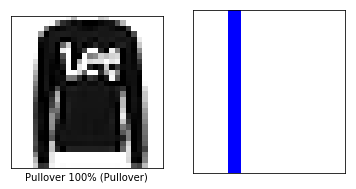

--------------------------------------------------


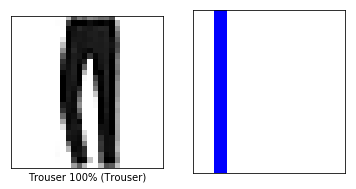

In [15]:
#随机展示两个图片的预测分类以及置信度可视化
i=1
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)
plt.show()

print(50*'-')

i=2
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)
plt.show()

##### 步骤4.4.3 预测更多的图片
- 正确的预测标签是蓝色的，错误的预测标签是红色的
- 数字给出了预测标签的置信度

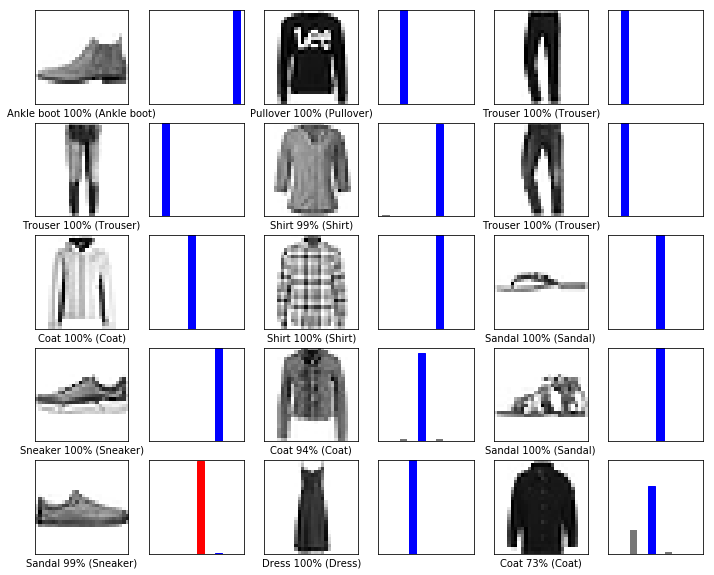

In [16]:
#绘制第一个测试集预测图像表示它们的预测标签和真实标签
#蓝色表示正确预测， 红色表示错误预测
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize = (2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)
plt.show()

### 步骤5 利用训练后的模型对单个图像进行预测
#### 步骤5.1 使用测试集数据

(28, 28)
(1, 28, 28)
[[2.4464665e-05 1.0995644e-15 9.9952769e-01 4.4303866e-17 4.3223592e-04
  1.2395785e-16 1.5603528e-05 9.4937801e-24 1.6048682e-16 2.2705318e-18]]


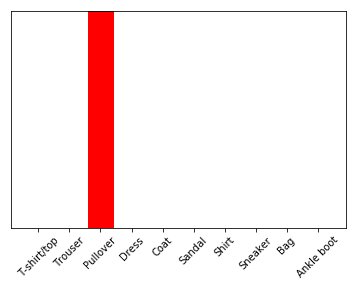

预测标签：2，它是：Pullover


In [18]:
# 从测试集中获取一个图形
img = test_images[1]

print(img.shape)
#为图形加上batch层
img = (np.expand_dims(img,0))
print(img.shape)

#预测图形的label
predictions_single = model.predict(img)
print(predictions_single)

#画出预测概率图
plot_value_array(0,predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

print('预测标签：%.0f，它是：%s'%(np.argmax(predictions_single[0]),class_names[np.argmax(predictions_single[0])]))

#### 步骤5.2 预测图片
准备了三张衣服的图像
##### 步骤5.2.1 将准备好的图片放至 ./image/ 下

In [20]:
import cv2

IMAGE_LIST = ['./image/t-shirt.jpg',
              './image/trouser.jpg',
              './image/dress.jpg'
                 ]
imgPath = []


def picture_load():
    for i, path in enumerate(IMAGE_LIST):
        imgpath = './image/'+ path.split('/')[-1].split('.')[0] + '.png'
        imgPath.append(imgpath)
        img = cv2.imread(path)
        cv2.imwrite(imgpath,img)       
        print('图像载入完成...')
picture_load()

图像载入完成...
图像载入完成...
图像载入完成...


##### 5.2.2 检测图像

--------------------真实图像--------------------


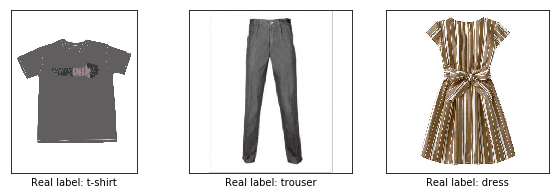

--------------------处理后的图像以及预测结果--------------------


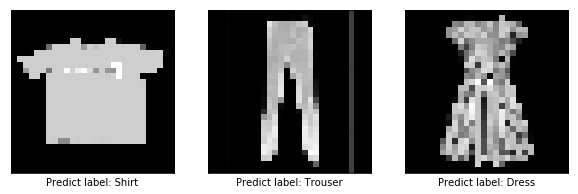

In [21]:
# 图像预处理
def preprocessing(image, height=28, width=28):
            
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 转换图像为单通道(灰度图)
    image = cv2.resize(image, (28,28)) # 调整图像尺寸为28*28
        
    image = -(image / 255.0) + 1   #归一化处理
    
    return image    

#图像预测
def predict(imgPath):
    print(20*'-' + '真实图像' + 20*'-')    
    
    plt.figure(figsize=(10,3))
    for i,path in enumerate(imgPath):
        plt.subplot(1, len(imgPath), i+1)        
       
        image = cv2.imread(path)  # 图像所在位置          
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('Real label: '+ path.split('/')[-1].split('.')[0])
        plt.imshow(image)
    plt.show()
    
    print(20*'-' + '处理后的图像以及预测结果' + 20*'-')
    
    plt.figure(figsize=(10,3))
    for i,path in enumerate(imgPath):
        plt.subplot(1, len(imgPath), i+1)
                
        image =  cv2.imread(path)
        image = preprocessing(image)
        
        plt.imshow(image, cmap = plt.get_cmap('gray'))
        image = np.expand_dims(image,0)
        predict_label = class_names[np.argmax(model.predict(image))]
        plt.xlabel('Predict label: '+ predict_label)
        plt.xticks([])
        plt.yticks([])        
    plt.show()
    
predict(imgPath)

### 总结
- 请调整模型参数，进一步提高模型的预测准确率；
- 使用其他图像进行预测